In [217]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os



In [218]:
filenames = os.listdir("../tob2/data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'c1':
        categories.append('0')
    if category == 'c2':
        categories.append('1')
    if category == 'c3':
        categories.append('2')
    if category == 'c4':
        categories.append('3')
        

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,c2.399.jpg,1
1,c3.642.jpg,2
2,c1.718.jpg,0
3,c1.274.jpg,0
4,c3.756.jpg,2


In [219]:
df

,filename,category
0,c2.399.jpg,1
1,c3.642.jpg,2
2,c1.718.jpg,0
3,c1.274.jpg,0
4,c3.756.jpg,2
...,...,...
3195,c1.578.jpg,0
3196,c4.511.jpg,3
3197,c2.231.jpg,1
3198,c1.500.jpg,0


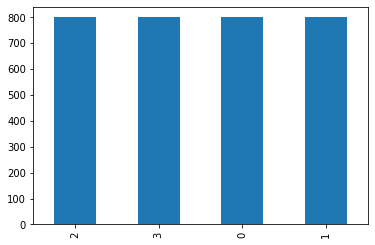

In [220]:
df['category'].value_counts().plot.bar()

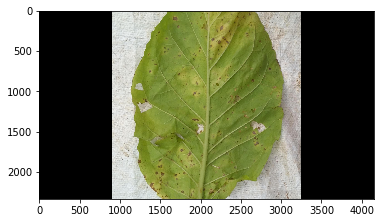

In [221]:
sample = random.choice(filenames)
image = load_img("../tob2/data/train/"+sample)
plt.imshow(image)

In [222]:
from keras import backend as K
K.clear_session()


In [223]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = True

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(4, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________

In [224]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [225]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../tob2/data/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2880 validated image filenames belonging to 4 classes.


In [227]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../tob2/data/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 320 validated image filenames belonging to 4 classes.


# VGG16 with trained weights

In [228]:
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/5
180/180 [==============================] - 593s 3s/step - loss: 0.5917 - accuracy: 0.7147 - val_loss: 0.4868 - val_accuracy: 0.7594
Epoch 2/5
180/180 [==============================] - 565s 3s/step - loss: 0.4774 - accuracy: 0.7748 - val_loss: 0.3298 - val_accuracy: 0.8258
Epoch 3/5
180/180 [==============================] - 438s 2s/step - loss: 0.3910 - accuracy: 0.8153 - val_loss: 0.3047 - val_accuracy: 0.8695
Epoch 4/5
180/180 [==============================] - 437s 2s/step - loss: 0.3441 - accuracy: 0.8359 - val_loss: 0.2966 - val_accuracy: 0.8805
Epoch 5/5
180/180 [==============================] - 448s 2s/step - loss: 0.3128 - accuracy: 0.8531 - val_loss: 0.3541 - val_accuracy: 0.8914


In [229]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.891406  ;  loss = 0.158571 


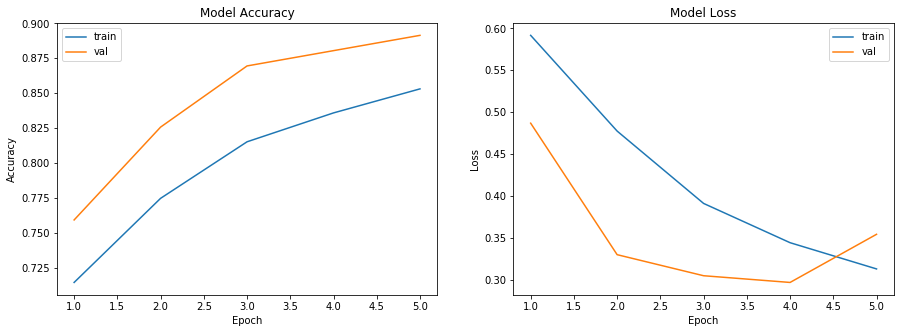

In [230]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [235]:
validate_df

0      1
1      1
2      2
3      1
4      2
      ..
315    3
316    0
317    1
318    0
319    1
Name: category, Length: 320, dtype: object

In [237]:
validate_df =validate_df.replace({ 0:'0', 1:'1',2:'2',3:'3'})
from sklearn.preprocessing import MultiLabelBinarizer
one_hot = MultiLabelBinarizer()
validate_df = one_hot.fit_transform(validate_df)


array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       ...,
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0]])

In [242]:
validate_df = [ np.argmax(t) for t in validate_df ]

In [238]:
y_pred =  model.predict_generator(validation_generator)
y_pred

array([[0.00547436, 0.01061931, 0.50503916, 0.39870137],
       [0.22065651, 0.42044926, 0.44455516, 0.0062584 ],
       [0.0024235 , 0.01250178, 0.00433624, 0.9951298 ],
       ...,
       [0.35822487, 0.6172117 , 0.07681778, 0.00777707],
       [0.00692347, 0.01122108, 0.67198545, 0.5551869 ],
       [0.13868135, 0.63954526, 0.24791801, 0.0062587 ]], dtype=float32)

In [239]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)
y_final = [ np.argmax(t) for t in y_final ]


[2,
 0,
 3,
 2,
 1,
 0,
 3,
 0,
 0,
 3,
 1,
 0,
 3,
 1,
 0,
 3,
 0,
 3,
 3,
 0,
 3,
 0,
 2,
 3,
 1,
 1,
 2,
 2,
 3,
 3,
 0,
 0,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 1,
 1,
 2,
 1,
 3,
 0,
 0,
 2,
 1,
 3,
 3,
 0,
 1,
 0,
 3,
 3,
 3,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 3,
 1,
 0,
 0,
 1,
 0,
 1,
 3,
 3,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 3,
 3,
 3,
 0,
 0,
 2,
 2,
 2,
 1,
 0,
 0,
 3,
 0,
 3,
 0,
 0,
 3,
 2,
 1,
 2,
 0,
 3,
 3,
 1,
 0,
 0,
 1,
 0,
 3,
 3,
 2,
 0,
 3,
 3,
 0,
 3,
 0,
 3,
 0,
 3,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 3,
 3,
 0,
 0,
 2,
 0,
 3,
 0,
 3,
 3,
 3,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 3,
 0,
 3,
 0,
 3,
 3,
 1,
 3,
 3,
 0,
 2,
 3,
 2,
 1,
 0,
 3,
 3,
 0,
 2,
 1,
 1,
 0,
 1,
 0,
 0,
 3,
 0,
 0,
 2,
 0,
 0,
 0,
 3,
 3,
 0,
 3,
 2,
 3,
 2,
 3,
 2,
 3,
 2,
 0,
 0,
 0,
 0,
 0,
 3,
 1,
 0,
 0,
 3,
 0,
 3,
 2,
 2,
 1,
 3,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 3,
 0,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 1,
 2,
 3,
 1,
 3,
 0,
 0,
 1,
 3,
 3,
 0,
 0,
 2,
 2,
 1,
 2,
 0,
 2,
 1,
 1,
 2,


In [241]:
y_final

[2,
 0,
 3,
 2,
 1,
 0,
 3,
 0,
 0,
 3,
 1,
 0,
 3,
 1,
 0,
 3,
 0,
 3,
 3,
 0,
 3,
 0,
 2,
 3,
 1,
 1,
 2,
 2,
 3,
 3,
 0,
 0,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 1,
 1,
 2,
 1,
 3,
 0,
 0,
 2,
 1,
 3,
 3,
 0,
 1,
 0,
 3,
 3,
 3,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 3,
 1,
 0,
 0,
 1,
 0,
 1,
 3,
 3,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 3,
 3,
 3,
 0,
 0,
 2,
 2,
 2,
 1,
 0,
 0,
 3,
 0,
 3,
 0,
 0,
 3,
 2,
 1,
 2,
 0,
 3,
 3,
 1,
 0,
 0,
 1,
 0,
 3,
 3,
 2,
 0,
 3,
 3,
 0,
 3,
 0,
 3,
 0,
 3,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 3,
 3,
 0,
 0,
 2,
 0,
 3,
 0,
 3,
 3,
 3,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 3,
 0,
 3,
 0,
 3,
 3,
 1,
 3,
 3,
 0,
 2,
 3,
 2,
 1,
 0,
 3,
 3,
 0,
 2,
 1,
 1,
 0,
 1,
 0,
 0,
 3,
 0,
 0,
 2,
 0,
 0,
 0,
 3,
 3,
 0,
 3,
 2,
 3,
 2,
 3,
 2,
 3,
 2,
 0,
 0,
 0,
 0,
 0,
 3,
 1,
 0,
 0,
 3,
 0,
 3,
 2,
 2,
 1,
 3,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 3,
 0,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 1,
 2,
 3,
 1,
 3,
 0,
 0,
 1,
 3,
 3,
 0,
 0,
 2,
 2,
 1,
 2,
 0,
 2,
 1,
 1,
 2,


In [243]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(validate_df,y_final)

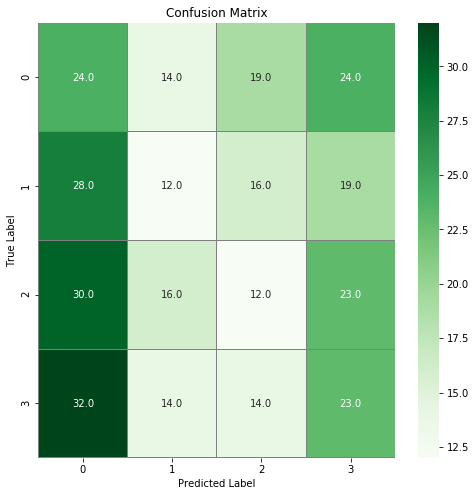

In [245]:
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [247]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(validate_df, y_final, target_names=['0','1','2','3'])

print(report)

              precision    recall  f1-score   support

           0       0.21      0.30      0.25        81
           1       0.21      0.16      0.18        75
           2       0.20      0.15      0.17        81
           3       0.26      0.28      0.27        83

    accuracy                           0.22       320
   macro avg       0.22      0.22      0.22       320
weighted avg       0.22      0.22      0.22       320



In [248]:
test_filenames = os.listdir("/home/shiv/Desktop/tob_train_extra")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [254]:
IMZ_SIZE=(224,224)
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/home/shiv/Desktop/tob_train_extra", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMZ_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 300 validated image filenames.


In [255]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [256]:
test_df['category'] = np.argmax(predict, axis=-1)

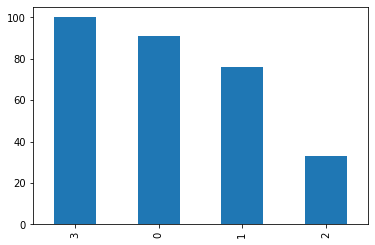

In [257]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'c1': 0, 'c2': 1,'c3': 2,'c4': 3})
test_df['category'].value_counts().plot.bar()

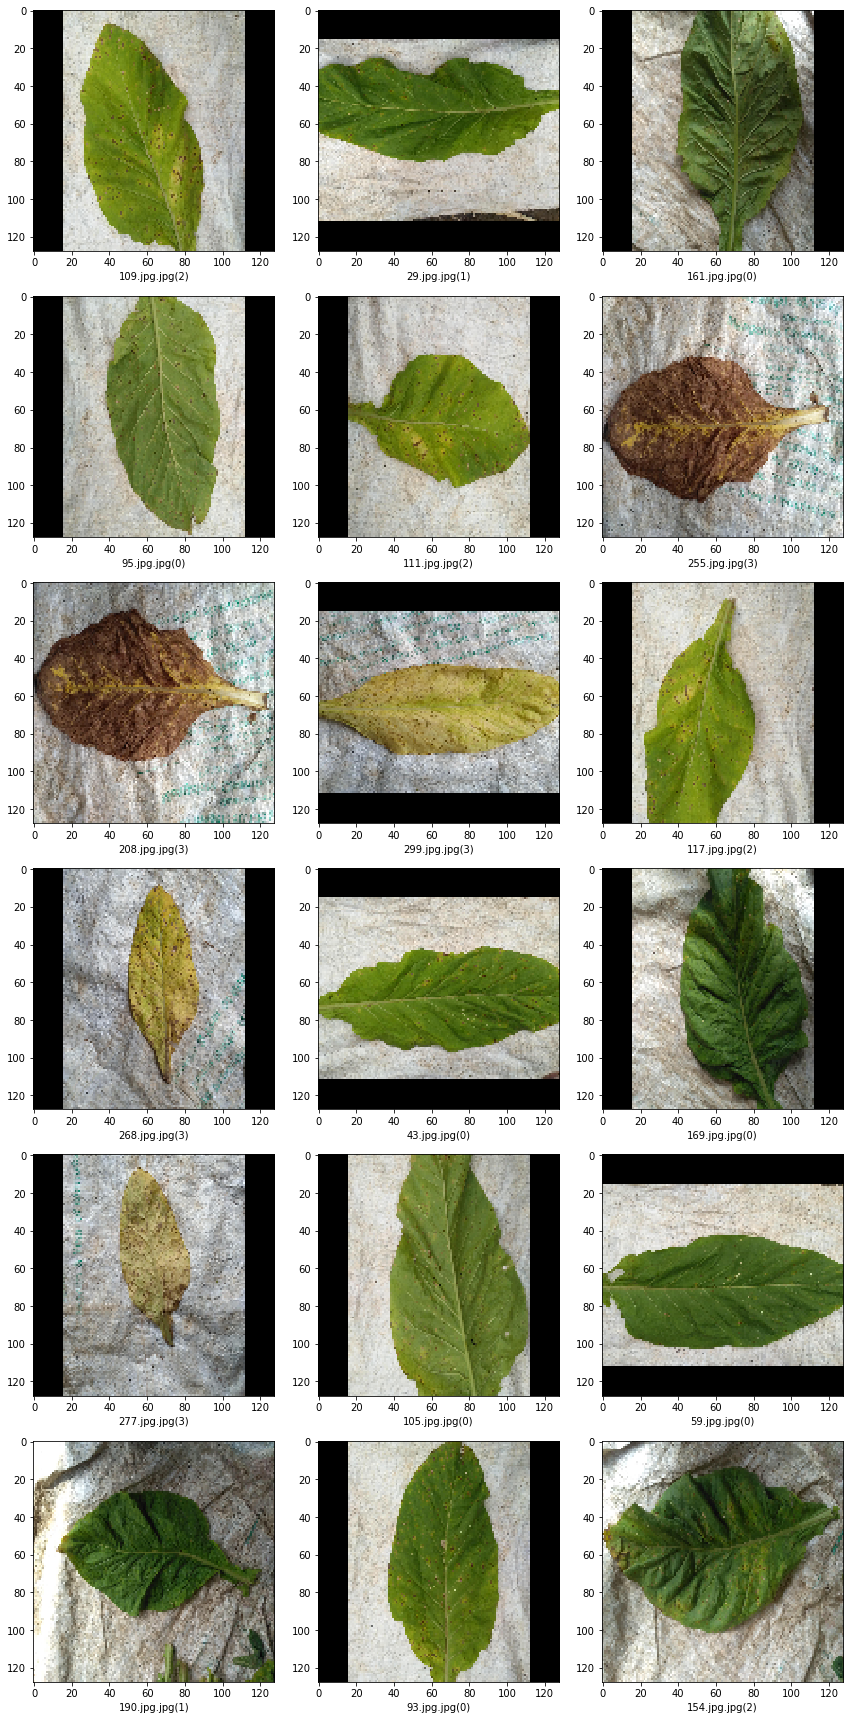

In [258]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/home/shiv/Desktop/tob_train_extra/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# START HERE

In [ ]:
#%%capture
#!pip install pydot
#!apt-get install graphviz
#!sed -i 's/def _check_pydot()/def _check__pydot()/g' /usr/local/lib/python3.6/dist-packages/keras/utils/vis_utils.py
#!sed -i 's/_check_pydot()/#_check_pydot()/g' /usr/local/lib/python3.6/dist-packages/keras/utils/vis_utils.py

In [150]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../tob2/data/train"))

['c2.399.jpg', 'c3.642.jpg', 'c1.718.jpg', 'c1.274.jpg', 'c3.756.jpg', 'c1.564.jpg', 'c2.386.jpg', 'c2.327.jpg', 'c3.798.jpg', 'c4.696.jpg', 'c2.321.jpg', 'c2.707.jpg', 'c4.147.jpg', 'c1.496.jpg', 'c1.799.jpg', 'c2.505.jpg', 'c1.477.jpg', 'c2.674.jpg', 'c3.134.jpg', 'c2.529.jpg', 'c2.423.jpg', 'c2.518.jpg', 'c2.591.jpg', 'c1.60.jpg', 'c1.15.jpg', 'c2.755.jpg', 'c2.205.jpg', 'c4.509.jpg', 'c3.86.jpg', 'c3.486.jpg', 'c3.44.jpg', 'c3.113.jpg', 'c3.130.jpg', 'c3.304.jpg', 'c4.113.jpg', 'c2.173.jpg', 'c3.61.jpg', 'c1.150.jpg', 'c1.586.jpg', 'c4.699.jpg', 'c1.478.jpg', 'c3.112.jpg', 'c4.2.jpg', 'c3.173.jpg', 'c2.133.jpg', 'c1.697.jpg', 'c2.495.jpg', 'c4.709.jpg', 'c4.338.jpg', 'c1.661.jpg', 'c4.254.jpg', 'c1.87.jpg', 'c4.546.jpg', 'c1.224.jpg', 'c1.254.jpg', 'c1.172.jpg', 'c2.138.jpg', 'c4.585.jpg', 'c4.563.jpg', 'c1.549.jpg', 'c4.750.jpg', 'c4.603.jpg', 'c4.224.jpg', 'c2.416.jpg', 'c4.727.jpg', 'c4.201.jpg', 'c1.738.jpg', 'c3.382.jpg', 'c3.295.jpg', 'c2.652.jpg', 'c2.510.jpg', 'c2.340.jpg',

In [151]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [152]:
filenames = os.listdir("../tob2/data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'c1':
        categories.append(0)
    elif category == 'c2':
        categories.append(1)
    elif category == 'c3':
        categories.append(2)
    else:
        categories.append(3)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [153]:
df['category'].value_counts()

3    800
1    800
2    800
0    800
Name: category, dtype: int64

# Multi-Layered CNN

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)      

In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [19]:
earlystop = EarlyStopping(patience=10)

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [21]:
callbacks = [earlystop, learning_rate_reduction]

In [22]:
df["category"] = df["category"].replace({0: 'c1', 1: 'c2', 2:'c3', 3:'c4'}) 

In [23]:
df.count()

filename    3200
category    3200
dtype: int64

In [24]:
df['category'].value_counts()

c2    800
c3    800
c4    800
c1    800
Name: category, dtype: int64

In [25]:
total_train =df.shape[0]

batch_size=15

In [26]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    df, 
    "../tob2/data/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3200 validated image filenames belonging to 4 classes.


In [27]:
df = df.reset_index(drop=True)
df

,filename,category
0,c2.399.jpg,c2
1,c3.642.jpg,c3
2,c1.718.jpg,c1
3,c1.274.jpg,c1
4,c3.756.jpg,c3
...,...,...
3195,c1.578.jpg,c1
3196,c4.511.jpg,c4
3197,c2.231.jpg,c2
3198,c1.500.jpg,c1


In [175]:
filenames = os.listdir("../tob2/data/validation")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'c1':
        categories.append(0)
    elif category == 'c2':
        categories.append(1)
    elif category == 'c3':
        categories.append(2)
    else:
        categories.append(3)

df1 = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [176]:
df1['category'].value_counts()

3    200
2    200
1    200
0    200
Name: category, dtype: int64

In [177]:
df1["category"] = df1["category"].replace({0: 'c1', 1: 'c2', 2:'c3', 3:'c4'}) 

In [178]:
df1["category"]

0      c4
1      c3
2      c1
3      c1
4      c3
       ..
795    c1
796    c4
797    c3
798    c3
799    c3
Name: category, Length: 800, dtype: object

In [179]:
df1 = df1.reset_index(drop=True)
df1

,filename,category
0,c4.147.jpg,c4
1,c3.134.jpg,c3
2,c1.60.jpg,c1
3,c1.15.jpg,c1
4,c3.86.jpg,c3
...,...,...
795,c1.197.jpg,c1
796,c4.169.jpg,c4
797,c3.154.jpg,c3
798,c3.84.jpg,c3


In [180]:
total_validate =df1.shape[0]

In [162]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df1, 
    "../tob2/data/validation", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 800 validated image filenames belonging to 4 classes.


# GENERATOR WORKING

In [ ]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

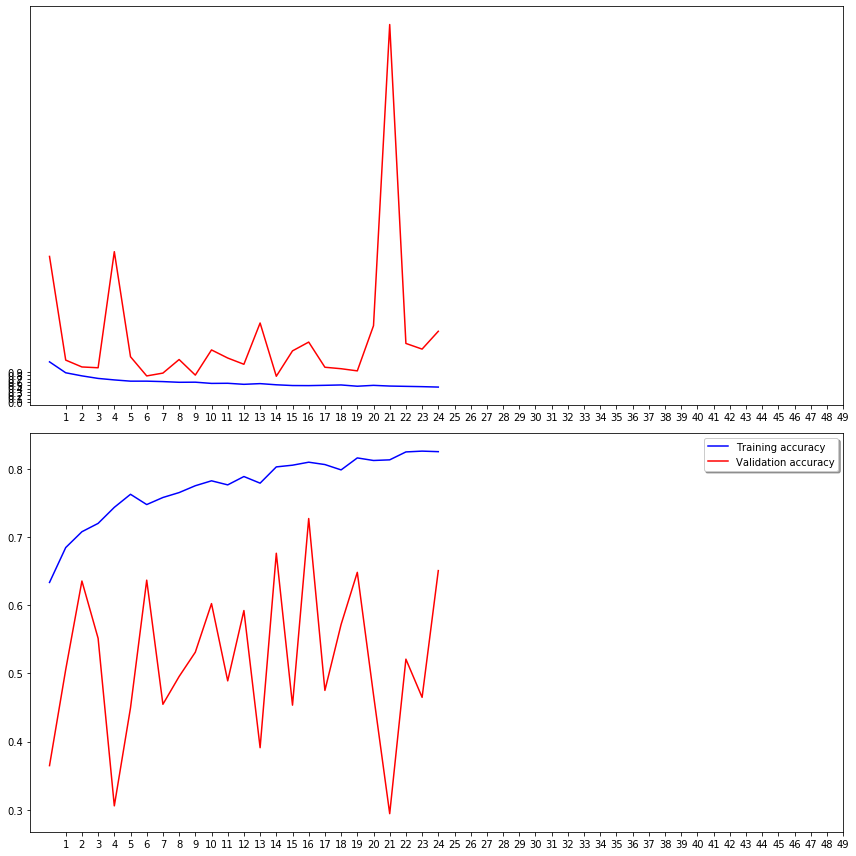

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [39]:
test_filenames = os.listdir("/home/shiv/Desktop/tob_train_extra")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [40]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/home/shiv/Desktop/tob_train_extra", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 300 validated image filenames.


In [41]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [42]:
test_df['category'] = np.argmax(predict, axis=-1)

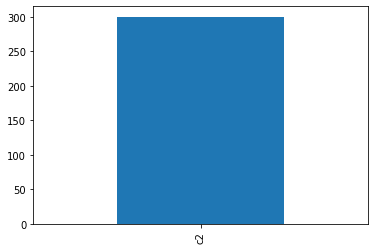

In [45]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'c1': 0, 'c2': 1,'c3': 2,'c4': 3})
test_df['category'].value_counts().plot.bar()

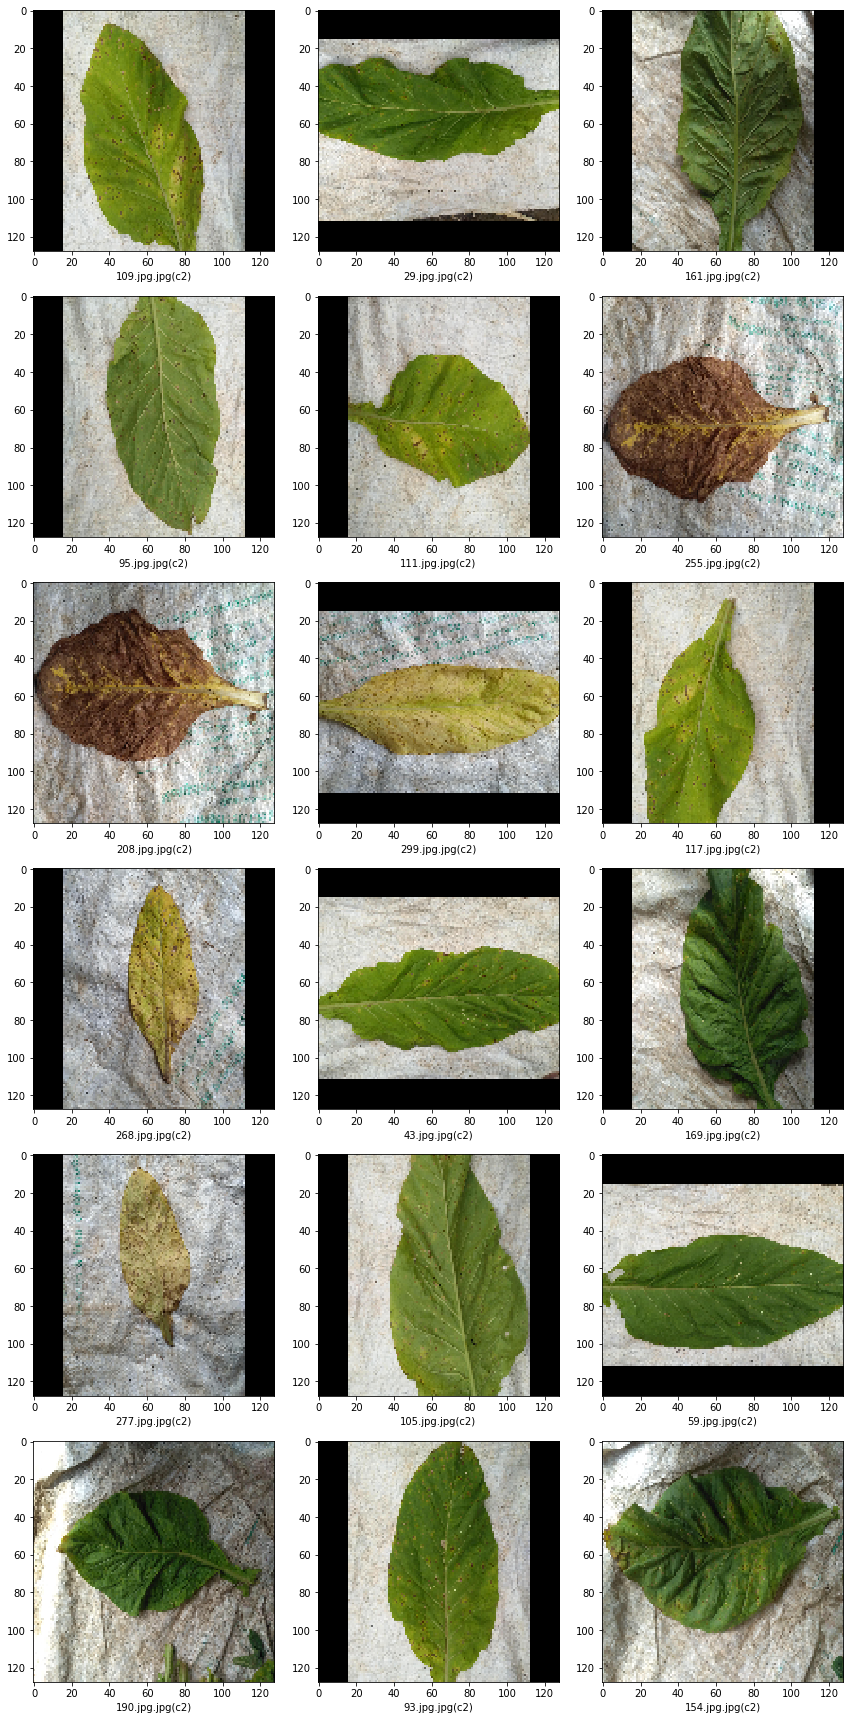

In [47]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/home/shiv/Desktop/tob_train_extra/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Alexnet Implementation


In [44]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'c1': 0, 'c2': 1,'c3': 2,'c4': 3})
test_df['category'].value_counts().plot.bar()

In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framewo

In [38]:
%%capture
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

def alexnet(input_shape, n_classes):
  input = Input(input_shape)
  
  # actually batch normalization didn't exist back then
  # they used LRN (Local Response Normalization) for regularization
  x = Conv2D(96, 11, strides=4, padding='same', activation='relu')(input)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Conv2D(256, 5, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
  x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
  x = Conv2D(256, 3, strides=1, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Flatten()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dense(4096, activation='relu')(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model


input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS);
n_classes = 4;
model = alexnet(input_shape,n_classes);


In [4]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        34944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 256)       614656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 256)       1024      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 256)         0   

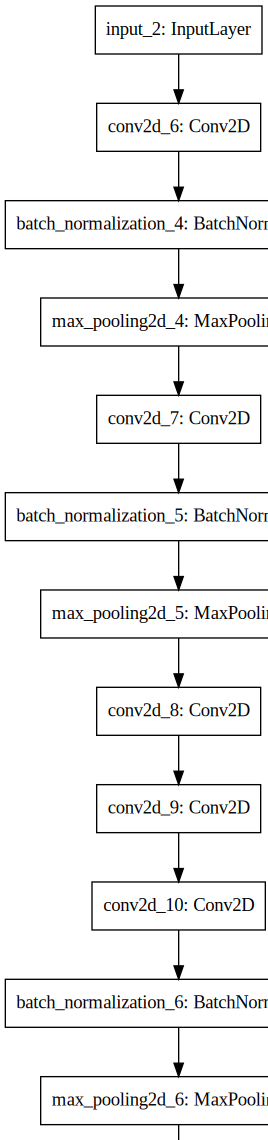

In [39]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [41]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
213/213 [==============================] - 560s 3s/step - loss: 3.6016 - acc: 0.3702 - val_loss: 1.7767 - val_acc: 0.2717
Epoch 2/50
213/213 [==============================] - 548s 3s/step - loss: 1.0052 - acc: 0.5799 - val_loss: 2.3312 - val_acc: 0.3490
Epoch 3/50
213/213 [==============================] - 562s 3s/step - loss: 0.8546 - acc: 0.6283 - val_loss: 4.6014 - val_acc: 0.5261
Epoch 4/50
213/213 [==============================] - 651s 3s/step - loss: 0.8366 - acc: 0.6549 - val_loss: 1.2869 - val_acc: 0.6357
Epoch 5/50
213/213 [==============================] - 619s 3s/step - loss: 0.8130 - acc: 0.6738 - val_loss: 0.2906 - val_acc: 0.6242
Epoch 6/50
213/213 [==============================] - 587s 3s/step - loss: 0.7306 - acc: 0.7030 - val_loss: 2.9417 - val_acc: 0.6127

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
213/213 [==============================] - 621s 3s/step - loss: 0.6430 - acc: 0.7469 - val_loss: 3.0845 - val_

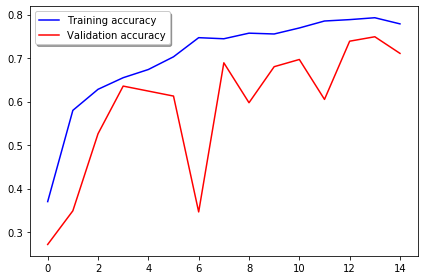

In [149]:

plt.plot(history.history['acc'], color='b', label="Training accuracy")
plt.plot(history.history['val_acc'], color='r',label="Validation accuracy")
#plt.set_xticks(np.arange(1, epochs[:15], 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [181]:
df1['category'] =df1['category'].replace({ 'c1':0,'c2':1,'c3':2,'c4':3})

In [195]:
Y_val=df1['category']

In [197]:
Y_val =Y_val.replace({ 0:'0', 1:'1',2:'2',3:'3'})

In [201]:
from sklearn.preprocessing import MultiLabelBinarizer
one_hot = MultiLabelBinarizer()
Y_val = one_hot.fit_transform(Y_val)

In [202]:
Y_val = [ np.argmax(t) for t in Y_val ]

In [205]:
y_pred =  model.predict_generator(validation_generator)
y_pred

array([[0.00000000e+00, 0.00000000e+00, 2.53147662e-37, 1.00000000e+00],
       [1.09952256e-01, 8.24513614e-01, 6.49178922e-02, 6.16213132e-04],
       [1.00954399e-01, 3.17758381e-01, 5.12458861e-01, 6.88283220e-02],
       ...,
       [3.34938109e-01, 6.13035500e-01, 5.15328459e-02, 4.93556960e-04],
       [3.57290264e-03, 3.09942126e-01, 6.28892064e-01, 5.75928055e-02],
       [1.06186857e-02, 4.55443487e-02, 8.65067065e-01, 7.87699223e-02]],
      dtype=float32)

In [206]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)
y_final = [ np.argmax(t) for t in y_final ]

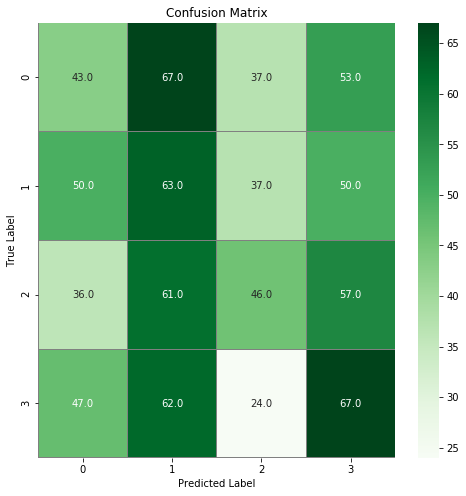

In [209]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [210]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, y_final, target_names=['0','1','2','3'])

print(report)

              precision    recall  f1-score   support

           0       0.24      0.21      0.23       200
           1       0.25      0.32      0.28       200
           2       0.32      0.23      0.27       200
           3       0.30      0.34      0.31       200

    accuracy                           0.27       800
   macro avg       0.28      0.27      0.27       800
weighted avg       0.28      0.27      0.27       800



In [211]:
test_filenames = os.listdir("/home/shiv/Desktop/tob_train_extra")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [212]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/home/shiv/Desktop/tob_train_extra", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 300 validated image filenames.


In [213]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [214]:
test_df['category'] = np.argmax(predict, axis=-1)

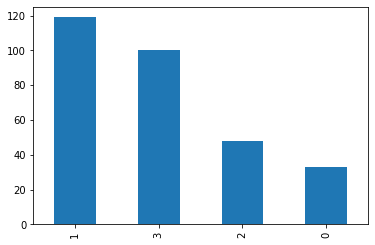

In [215]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'c1': 0, 'c2': 1,'c3': 2,'c4': 3})
test_df['category'].value_counts().plot.bar()

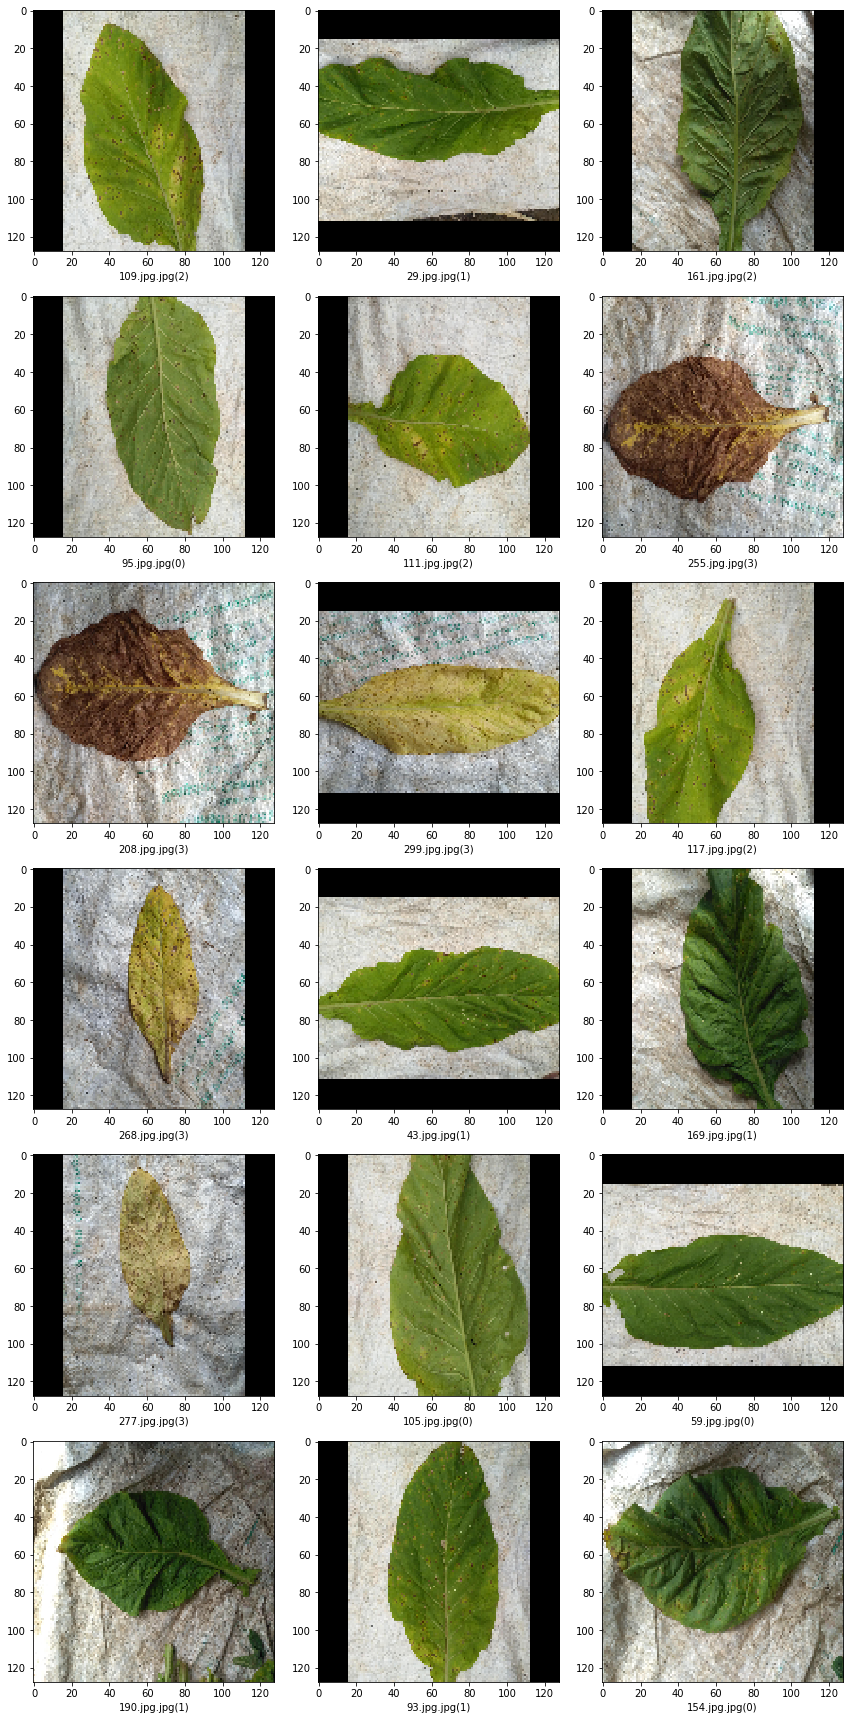

In [216]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/home/shiv/Desktop/tob_train_extra/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()